In [1]:

import yaml
from train_eval.trainer import Trainer
import torch
import torch.nn as nn
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"


2023-02-10 00:27:53,869	INFO worker.py:1518 -- Started a local Ray instance.


In [2]:
def get_unfolded_feature(feature,kernel,mask):
    ## Input shape B,C,H,W
    channel=feature.shape[1]
    unfold = nn.Unfold(kernel_size=(kernel, kernel), dilation=1, padding=kernel//2, stride=(1, 1))
    unfolded_feature=unfold(feature).permute(0,2,1) ## B,Number of slided window, channel*Number of elements in every window
    # unfolded_feature=unfolded_feature.view(unfolded_feature.shape[0],unfolded_feature.shape[1],channel,kernel**2)
    current_node_feat=feature.view(feature.shape[0],channel,-1).permute(0,2,1)## B,Number of slided window, channel
    # unfolded_feature=(unfolded_feature*mask.unsqueeze(-1)).to_sparse()
    # current_node_feat=(current_node_feat*mask.unsqueeze(-1)).to_sparse()
    target_feat=[]
    source_feat=[]
    for idx,batch in enumerate(current_node_feat):
        source_feat.append(batch[mask[idx]])
        target_feat.append(unfolded_feature[idx][mask[idx]])
    return source_feat,target_feat
source_feat,target_feat=get_unfolded_feature(op,15,mask_map)

NameError: name 'op' is not defined

In [ ]:
x_coord,y_coord=torch.meshgrid(torch.arange(15//2,-((15//2)+1),-1),
                                torch.arange(-(15//2),((15//2)+1),1))
diff=torch.cat([x_coord.unsqueeze(0),y_coord.unsqueeze(0)],dim=0)
diff=diff.view(2,-1).T
# diff

In [2]:
with open("/home/stanliu/code/pgp/PGP/configs/raster.yml", 'r') as yaml_file:
    cfg = yaml.safe_load(yaml_file)

In [ ]:
ds_type = cfg['dataset'] + '_' + cfg['agent_setting'] + '_' + cfg['input_representation']
# cfg
# cfg['encoder_args']
# cfg.keys()

In [3]:
from train_eval.trainer import Trainer
# from torch.utils.tensorboard import SummaryWriter
# import os
# writer = SummaryWriter(log_dir=os.path.join('/home/stanliu/code/pgp/PGP/output/test_ram', 'tensorboard_logs'))
trainer = Trainer(cfg, "/home/stanliu/data/mnt/nuScenes/", "/home/stanliu/code/pgp/PGP/preprocess_raster")
# trainer = Trainer(cfg, "/home/stanliu/data/mnt/nuScenes/", "/home/stanliu/code/pgp/PGP/preprocess_raster",checkpoint_path='/home/stanliu/code/pgp/PGP/output/test_ram/checkpoints/8.tar')

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 38.524 seconds.
Reverse indexing ...
Done reverse indexing in 10.3 seconds.


In [4]:
import train_eval.utils as u
for i,data in enumerate(trainer.tr_dl):
    torch.cuda.empty_cache()
    # Load data
    data = u.send_to_device(u.convert_double_to_float(data))
    data_test=data['inputs']
    gt_test=data['ground_truth']
    break


In [6]:
import time
import train_eval.utils as u
mode = 'val'
with torch.no_grad():
    if mode == 'val':
        trainer.model.eval()

    # Initialize epoch metrics
    epoch_metrics = trainer.initialize_metrics_for_epoch(mode)

    # Main loop
    st_time = time.time()
    for i, data in enumerate(trainer.tr_dl):
        torch.cuda.empty_cache()
        # Load data
        data = u.send_to_device(u.convert_double_to_float(data))
        data['inputs']['gt_traj']= None
        # Forward pass
        predictions = trainer.model(data['inputs'])


        # Compute loss and backprop if training

        # Keep time
        minibatch_time = time.time() - st_time
        st_time = time.time()

        # Aggregate metrics
        minibatch_metrics, epoch_metrics = trainer.aggregate_metrics(epoch_metrics, minibatch_time,
                                                                    predictions, data['ground_truth'], mode)



        # Display metrics at a predefined frequency
        # if i % trainer.log_period == trainer.log_period - 1:
        trainer.print_metrics(epoch_metrics, trainer.tr_dl, mode)
        break

    # Log val metrics for the complete epoch to tensorboard
    if mode == 'val':
        trainer.log_tensorboard_val(epoch_metrics)


Validating: [                    ] 0 %, ETA: 83153s, Metrics: { focal_loss: nan, min_ade_loss: 5.71, miss_rate_10: 1.00, min_ade_loss: 5.71, miss_rate_5: 1.00, min_fde_10: 4.47 }

AttributeError: 'NoneType' object has no attribute 'add_scalar'

In [5]:
focal=trainer.losses[0]
ade=trainer.losses[1]
# dri_loss=trainer.losses[1]


In [6]:
data_test['gt_traj']=data['ground_truth']['traj']
data_test['gt_traj']=None

In [8]:
# data['ground_truth']['traj']
map_representation = data_test['map_representation'][0]
mask=data_test['map_representation'][1]


mask.shape

torch.Size([4, 488, 488])

In [ ]:
import torch.nn as nn
unfold = nn.Unfold(kernel_size=(7, 7), dilation=1, padding=7//2, stride=(1, 1))
unfold(mask.unsqueeze(1)).shape

In [ ]:
from models.library.RasterSampler import *
sampler = Sampler(cfg['aggregator_args'],resolution=1.0,apply_mask=True)
nodes_2D=sampler.sample_goals(mask)
mask_under=sampler.sample_mask(mask)

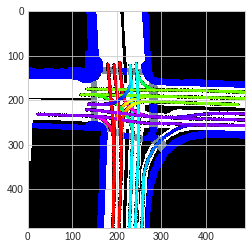

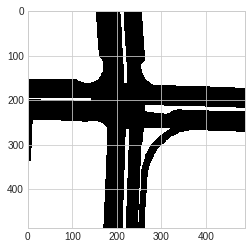

In [9]:
import matplotlib.pyplot as plt

plt.imshow(map_representation[0].permute(1,2,0))
plt.show()
plt.imshow(mask[0])
plt.show()

In [3]:
import torch
from math import exp
from torch.autograd import Variable
import torch.nn.functional as F
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss#/gauss.sum()
def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 0.8).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window
window=create_window(5, 1)
window


tensor([[[[0.0019, 0.0201, 0.0439, 0.0201, 0.0019],
          [0.0201, 0.2096, 0.4578, 0.2096, 0.0201],
          [0.0439, 0.4578, 1.0000, 0.4578, 0.0439],
          [0.0201, 0.2096, 0.4578, 0.2096, 0.0201],
          [0.0019, 0.0201, 0.0439, 0.0201, 0.0019]]]])

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data_test['surrounding_agent_representation'][4,:3].permute(1,2,0))
plt.show()
# plt.imshow(test_heatmap[0,0])
# plt.show()
# data['ground_truth']['traj']

In [ ]:
data_test['map_representation'].keys()

In [ ]:
print('lane_node_feats has shape of ',data_test['map_representation']['lane_node_feats'].shape)
print('lane_node_masks has shape of ',data_test['map_representation']['lane_node_masks'].shape)
print('s_next has shape of ',data_test['map_representation']['s_next'].shape)
print('edge_type has shape of ',data_test['map_representation']['edge_type'].shape)

In [7]:
from torch.autograd.profiler import profile, record_function
with profile( profile_memory=True, record_shapes=True) as prof:
    encodings=trainer.model.encoder(data_test)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::empty         3.58%      10.397ms         3.58%      10.397ms      58.410us           0 b           0 b     849.36 Mb     849.36 Mb           178  
                    aten::resize_         0.20%     588.359us         0.20%     588.359us      11.315us           0 b           0 b     176.06 Mb     176.06 Mb            52  
              aten::empty_strided         0.48%       1.397ms         0.48%       1.397ms     279.439us       1.82 Mb  

In [8]:
torch.cuda.empty_cache()
with profile( profile_memory=True, record_shapes=True) as prof:
    agg_feat=trainer.model.aggregator(encodings)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

# connectivities=agg_feat['node_connectivity']
# mask_map=agg_feat['under_sampled_mask']
# init=agg_feat['initial_states']
# print(connectivities.requires_grad)
# print(mask_map.requires_grad)

--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     aten::empty        61.46%      15.274ms        61.46%      15.274ms     227.969us           0 b           0 b       9.57 Gb       9.57 Gb            67  
                   aten::resize_         3.08%     765.613us         3.08%     765.613us      42.534us     234.47 Kb     234.47 Kb     309.74 Mb     309.74 Mb            18  
             aten::empty_strided         0.28%      68.526us         0.28%      68.526us      17.131us     116.28 Kb     116

In [9]:
print(agg_feat.keys())
print(agg_feat['node_connectivity'][0].shape)
# inputs=agg_feat
# attn_output_weights = inputs['node_connectivity']
# print(attn_output_weights[0].shape)
# init_states=inputs['initial_states']
# target_encodings = inputs['target_encodings']
# map_feature=inputs['feature'].permute(0,2,3,1) 
# mask=inputs['under_sampled_mask']  
      
# print(agg_feat['node_connectivity'].shape)
# print((agg_feat['initial_states'].indices().nelement() * agg_feat['initial_states'].indices().element_size() + agg_feat['initial_states'].values().nelement() *agg_feat['initial_states'].values().element_size()) / 1024**2)

dict_keys(['node_connectivity', 'under_sampled_mask', 'feature', 'target_encodings'])
torch.Size([16646, 625])


In [22]:
from models.decoders.ram_decoder import get_index
self=trainer.model.aggregator
init_states=torch.zeros(1,self.H,self.W)
init_states[:,self.compensation.long()]=1
init_states=init_states[:,self.source_row-self.center_row:][agg_feat['under_sampled_mask'].view(1,self.H,self.W)[:,self.source_row-self.center_row:]]

In [21]:
indices=get_index()

torch.Size([16646])

In [10]:
# test_feat=op.view(op.shape[0],op.shape[1],-1).permute(0,2,1)
torch.cuda.empty_cache()


In [9]:

with profile( profile_memory=True, record_shapes=True) as prof:
    predictions=trainer.model.decoder(agg_feat)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))
# print(predictions['pred'].element_size() * predictions['pred'].nelement()/ 1024**2)
# pred=predictions['pred'].to_sparse()
# print(pred.element_size() * pred.nelement()/ 1024**2)

# print((pred.indices().nelement() * pred.indices().element_size() + pred.values().nelement() * pred.values().element_size()) / 1024**2)

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::empty         3.99%       7.977ms         3.99%       7.977ms       3.963us         640 b         640 b      45.74 Mb      45.74 Mb          2013  
                aten::resize_         2.37%       4.731ms         2.37%       4.731ms       3.571us     235.09 Kb     235.09 Kb      13.21 Mb      13.21 Mb          1325  
          aten::empty_strided         0.04%      88.297us         0.04%      88.297us       8.027us           0 b           0 b     268.00 

In [13]:
# print(predictions['pred'].shape)
normalized_pred=predictions['pred']/(torch.max(predictions['pred'],dim=-1,keepdim=True)[0])
print(torch.max(predictions['pred'],dim=-1,keepdim=True)[0])
print(torch.max(normalized_pred,dim=-1,keepdim=True)[0])

tensor([[[0.3582],
         [0.1584],
         [0.1020],
         [0.0510],
         [0.0437],
         [0.0325],
         [0.0227],
         [0.0179],
         [0.0186],
         [0.0184],
         [0.0178],
         [0.0173]],

        [[0.4303],
         [0.2177],
         [0.1216],
         [0.0792],
         [0.0687],
         [0.0575],
         [0.0365],
         [0.0202],
         [0.0148],
         [0.0130],
         [0.0120],
         [0.0108]],

        [[0.3556],
         [0.1934],
         [0.1086],
         [0.0768],
         [0.0568],
         [0.0367],
         [0.0304],
         [0.0190],
         [0.0181],
         [0.0163],
         [0.0147],
         [0.0136]],

        [[0.2583],
         [0.1629],
         [0.1187],
         [0.0900],
         [0.0696],
         [0.0543],
         [0.0454],
         [0.0435],
         [0.0425],
         [0.0421],
         [0.0419],
         [0.0417]]], device='cuda:0', grad_fn=<MaxBackward0>)
tensor([[[1.],
         [1.],
         

In [60]:
focal=trainer.losses[0]
focal.horizon=12

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


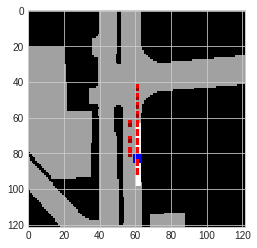

In [30]:
traj_idx=0
idx=2
import matplotlib.pyplot as plt
from models.decoders.ram_decoder import get_index,get_dense
gt_map=trainer.losses[0].generate_gtmap(predictions['traj'][:,traj_idx].view(predictions['traj'].shape[0],-1,predictions['traj'].shape[-1]).clone().detach(),predictions['mask'],visualize=True)
gt_map=torch.clamp(torch.sum(gt_map,dim=1,keepdim=True),0.0,1.0)
mask_map=gt_map.clone()
mask_map[predictions['mask'].view(gt_map.shape)]=0.005
gt_map+=mask_map
gt_map=gt_map.repeat(1,3,1,1)
gt_map*=127
endpoints=predictions['endpoints']
for batch in range(gt_map.shape[0]):
    for i,point in enumerate(endpoints[batch]):
        if i== traj_idx:
            x,y=point
            gt_map[batch,-1,max(0,x-2):min(x+3,trainer.losses[0].H),max(0,y-2):min(trainer.losses[0].W,y+3)]=255
            gt_map[batch,:-1,max(0,x-2):min(x+3,trainer.losses[0].H),max(0,y-2):min(trainer.losses[0].W,y+3)]=0
        else:
            x,y=point
            gt_map[batch,0,max(0,x-1):min(x+1,trainer.losses[0].H),max(0,y-1):min(trainer.losses[0].W,y+1)]=255
            gt_map[batch,1:,max(0,x-1):min(x+3,trainer.losses[0].H),max(0,y-1):min(trainer.losses[0].W,y+1)]=0

gt_map=gt_map.permute(0,2,3,1)
# normalize_factor,_=torch.max(dense_pred.view(dense_pred.shape[0],-1),dim=-1)
plt.imshow(gt_map[idx].cpu())
plt.show()
# plt.imshow(mask[idx])
# plt.show()
# gt_map.shape

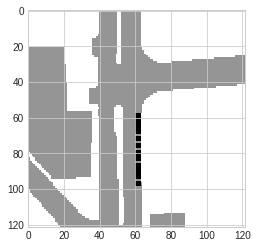

In [31]:
# idx=3
# traj_idx=0
import matplotlib.pyplot as plt
from models.decoders.ram_decoder import get_index,get_dense
gt_map=trainer.losses[0].generate_gtmap(data['ground_truth']['traj'],predictions['mask'],visualize=True)
gt_map=torch.sum(gt_map,dim=1,keepdim=True)
mask_map=torch.zeros_like(gt_map)
mask_map[predictions['mask'].view(gt_map.shape)]=1
gt_map+=mask_map
# gt_map=gt_map.permute(0,2,3,1)
# normalize_factor,_=torch.max(dense_pred.view(dense_pred.shape[0],-1),dim=-1)
plt.imshow(gt_map[idx].squeeze(0).cpu())
plt.show()

In [32]:
loss=ade.compute(predictions,gt_test)

In [44]:
sum=predictions['init_states'].view(predictions['init_states'].shape[0],-1).sum(dim=-1)
corrupt_idx=torch.argmin(sum).item()
corrupt_map=predictions['mask'][corrupt_idx].view(trainer.model.decoder.H,trainer.model.decoder.W)
print(corrupt_map[trainer.model.decoder.compensation[0]-1:trainer.model.decoder.compensation[0]+2,trainer.model.decoder.compensation[1]-1:trainer.model.decoder.compensation[1]+2])

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]], device='cuda:0')


In [19]:
init_pos=torch.zeros([122,122],device=predictions['mask'].device)
init_pos[trainer.model.decoder.compensation[0],trainer.model.decoder.compensation[1]]=1
mask_local=(predictions['mask'][0].view(122,122))[trainer.model.decoder.compensation[0]-1:trainer.model.decoder.compensation[0]+2,trainer.model.decoder.compensation[1]-1:trainer.model.decoder.compensation[1]+2]
valid_node_num=mask_local.float().sum()
init_pos[trainer.model.decoder.compensation[0]-1:trainer.model.decoder.compensation[0]+2,trainer.model.decoder.compensation[1]-1:trainer.model.decoder.compensation[1]+2]=1/valid_node_num.item()

In [20]:
init_pos[trainer.model.decoder.compensation[0]-1:trainer.model.decoder.compensation[0]+2,trainer.model.decoder.compensation[1]-1:trainer.model.decoder.compensation[1]+2]

tensor([[0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111]], device='cuda:0')

In [22]:
((init_pos.view(-1))[predictions['mask'][0]]).sum()

tensor(1., device='cuda:0')

In [11]:
loss+=ade.compute(predictions,gt_test)

In [17]:
torch.cuda.empty_cache()

In [12]:
loss.backward()

In [12]:
predictions['mask'].sum(-1)


tensor([14016, 10258], device='cuda:0')

In [ ]:
inputs = agg_feat
attn_output_weights = inputs['node_connectivity']
init_states=inputs['initial_states']


mask=inputs['under_sampled_mask']
target_encodings = inputs['target_encodings']
map_feature=inputs['feature'].permute(0,2,3,1)

In [ ]:
torch.cuda.empty_cache()
predictions=torch.empty([init_states.shape[0],0,init_states.shape[-1]],device=attn_output_weights.device)
prev_states=init_states.unsqueeze(1).to_dense()

for step in range(12):
    predictions=torch.cat((predictions,torch.bmm(prev_states,attn_output_weights)),dim=1)
    prev_states=predictions[:,step].unsqueeze(1)

torch.cuda.empty_cache()

In [ ]:
map_extent= [-61, 61, -22, 100]
from models.decoders.ram_decoder import get_dense,get_index
nodes_2D=get_index(predictions[:,-1].unsqueeze(1),mask)
dense_pred=get_dense(predictions[:,-1].unsqueeze(1),nodes_2D,122,122)
endpoints,confidences = trainer.model.decoder.endpoint_sampler(dense_pred)
endpoints=endpoints.long()
concat_feature=torch.empty([0,12,90],device=attn_output_weights.device)
x_coord,y_coord=torch.meshgrid(torch.arange(map_extent[-1],map_extent[-2],-1), ##### SHould be changed when image size changes
                                torch.arange(map_extent[0],map_extent[1],1))
indices=torch.cat([x_coord.unsqueeze(-1),y_coord.unsqueeze(-1)],dim=-1).to(attn_output_weights.device)
for batch_idx in range(len(dense_pred)):
    map_feat = (map_feature[batch_idx])[endpoints[batch_idx,:,0],endpoints[batch_idx,:,1]]
    diff = indices[endpoints[batch_idx,:,0],endpoints[batch_idx,:,1]].float()

    feature=torch.cat([map_feat,trainer.model.decoder.diff_encoder(diff),target_encodings[batch_idx].repeat(trainer.model.decoder.endpoint_sampler._n_targets,1)],dim=-1).unsqueeze(0)
    concat_feature=torch.cat([concat_feature,feature],dim=0)

In [ ]:
print(torch.cuda.memory_summary(0))

In [ ]:
pred=predictions['pred']
mask=predictions['mask']
traj_gt = gt_test['traj']

In [ ]:
import torch.nn.functional as F
with profile( profile_memory=True, record_shapes=True) as prof:
    swapped=torch.zeros_like(traj_gt).to(pred.device)
    swapped[:,:,0],swapped[:,:,1]=-traj_gt[:,:,1],traj_gt[:,:,0]
    coord=torch.round(swapped/trainer.losses[0].resolution+trainer.losses[0].compensation).int()
    coord=torch.clamp(coord,0,122)
    gt_map=torch.zeros([6,12,122,122],device=pred.device)
    for batch in range(6):
        for t in range(12):
            x,y=coord[batch,t]
            gt_map[batch,t,x,y]=1##Only one ground truth in each heatmap layer
    gs_map=F.conv2d(gt_map, trainer.losses[0].window, padding = trainer.losses[0].window_size//2, groups = trainer.losses[0].horizon)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
with profile( profile_memory=True, record_shapes=True) as prof:
    loss_mask = (reduced_gts == 1).float()
    pred_heatmap = torch.clamp(pred, min=1e-4)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
with profile( profile_memory=True, record_shapes=True) as prof:
    loss=-torch.sum(
                    torch.pow(pred_heatmap - reduced_maps, 2) * (
                    loss_mask * torch.log(pred_heatmap)
                    +
                    (1-loss_mask) * (torch.pow(1 - reduced_maps, 4) * torch.log(1 - pred_heatmap))
                )
            )
    loss.backward()
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
torch.cuda.empty_cache()
with profile( profile_memory=True, record_shapes=True) as prof:
    trainer.optimizer.step()
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))


In [ ]:
with profile( profile_memory=True, record_shapes=True) as prof:
    gs_map=gs_map.view([6,12,-1])
    gt_map=gt_map.view([6,12,-1])
    max_num=max(mask.sum(dim=1))
    reduced_maps=[]
    reduced_gts=[]
    for i,batch in enumerate(gs_map):
        reduced_map=batch[mask[i].repeat(12,1)].view(12,-1)
        reduced_gt=gt_map[i][mask[i].repeat(12,1)].view(12,-1)
        aug_map=torch.cat((reduced_map, torch.zeros(12,max_num - reduced_map.size(1),device=pred.device)), -1)
        aug_gt=torch.cat((reduced_gt, torch.zeros(12,max_num - reduced_map.size(1),device=pred.device)), -1)
        reduced_maps.append(aug_map.unsqueeze(0))
        reduced_gts.append(aug_gt.unsqueeze(0))
    reduced_maps=torch.cat(reduced_maps,dim=0).to(pred.device)
    reduced_gts=torch.cat(reduced_gts,dim=0).to(pred.device)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
reduced_gts.sum()

In [ ]:
def get_index(pred,mask):
    x_coord,y_coord=torch.meshgrid(torch.arange(0,122,1),
                                torch.arange(0,122,1))
    nodes_candidates=torch.cat((x_coord.unsqueeze(0),y_coord.unsqueeze(0)),dim=0).view(2,-1).T
    nodes_2D=torch.zeros([mask.shape[0],pred.shape[-1],2])
    for i in range(mask.shape[0]):
        nodes_batch=nodes_candidates[mask[i]]
        nodes_2D[i,:nodes_batch.shape[0]]=nodes_batch
    return nodes_2D.int().permute(0,2,1).to(pred.device)
nodes_2D=get_index(pred,mask)
nodes_2D.shape

In [ ]:
def get_dense(pred,nodes_2D,H,W):
    dense_rep=torch.empty(0,pred.shape[1],H,W,device=pred.device)
    for batch in range(pred.shape[0]):
        batch_heatmap=torch.empty(0,H,W,device=pred.device)
        for step in range(pred.shape[1]):
            heatmap=torch.sparse_coo_tensor(nodes_2D[batch],pred[batch,step],(122,122))
            batch_heatmap=torch.cat((batch_heatmap,heatmap.to_dense().unsqueeze(0)),dim=0)
        dense_rep=torch.cat((dense_rep,batch_heatmap.unsqueeze(0)),dim=0)
    return dense_rep
dense_rep=get_dense(pred,nodes_2D,122,122)

In [ ]:
predictions['probs']=predictions['prob']

In [ ]:


with profile( profile_memory=True, record_shapes=True) as prof:

# loss=pred.sum()
    loss=focal.compute(predictions,gt_test)
    loss+=ade.compute(predictions,gt_test)
    loss.backward()
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
trainer.model.aggregator

In [ ]:
pred = predictions['pred']
mask_da = predictions['mask'].view(-1,pred.shape[-2],pred.shape[-1]).unsqueeze(1)
ground_truth = gt_test
traj_gt = ground_truth['traj'] if type(ground_truth) == dict else ground_truth
true_heatmap,gs_map = focal.generate_gtmap(traj_gt,pred.shape)
gs_map=gs_map*mask_da
mask = (true_heatmap == 1).float()
pred_heatmap = torch.clamp(pred, min=1e-4)

In [ ]:
loss= focal()

In [ ]:
loss.backward()

In [ ]:
pred = predictions['pred']
mask = predictions['mask'].view(-1,pred.shape[-2],pred.shape[-1]).unsqueeze(1)
non_drivable_area_mask=~mask

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(non_drivable_area_mask[0,0].cpu())
plt.show()
plt.imshow(torch.zeros_like(non_drivable_area_mask[0,0].cpu()))
plt.show()

In [ ]:
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.nuscenes import NuScenes
map_extent=[ -50, 50, -20, 80 ]
img_size=[400,400]
resolution = (map_extent[1] - map_extent[0]) /  img_size[1]
nusc = NuScenes(version='v1.0-trainval', dataroot="/home/stanliu/data/mnt/nuScenes/", verbose=True)
helper=PredictHelper(nusc)
map_rasterizer = StaticLayerRasterizer(helper,
                                        resolution=resolution,
                                        meters_ahead=map_extent[3],
                                        meters_behind=-map_extent[2],
                                        meters_left=-map_extent[0],
                                        meters_right=map_extent[1])

In [ ]:
import torch
target_agent_representation = data_test['target_agent_representation']
surrounding_agent_representation = data_test['surrounding_agent_representation']
map_representation = data_test['map_representation'][0]
mask= data_test['map_representation'][1].type(torch.bool)
mask.shape

In [ ]:
idx=10
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.array(mask[idx]))
plt.show()
plt.imshow(np.array(map_representation[idx]).transpose(1,2,0))

In [ ]:

from torchvision.models import resnet34
# input = torch.cat((map_representation, surrounding_agent_representation), dim=1)
# resnet_model = resnet34(pretrained=False)
# conv1_new = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# modules = list(resnet_model.children())[:-2]

# modules[0] = conv1_new
# backbone = nn.Sequential(*modules)
# data_test['target_agent_representation'].float().dtype

In [ ]:
from models.encoders.raster_encoder import *
encoder=RasterEncoder(cfg['encoder_args'])
# encodings=encoder.forward(data_test)

In [ ]:
encodings['context_encoding']["combined"].shape

In [ ]:
import torch
import torch.nn.modules as nn
fake_map_encodings=torch.randn(32, 512, 16,16)
fake_agent_input=torch.randn(32, 32).unsqueeze(2).unsqueeze(3).repeat(1,1,16,16)

In [ ]:
concatenated_encodings=torch.cat([fake_map_encodings,fake_agent_input],dim=1)
conv1d1=nn.Conv2d(544, 528, kernel_size=1, stride=1, bias=False)
conv1d2=nn.Conv2d(528, 512, kernel_size=1, stride=1, bias=False)
test_dim_reduction=nn.Sequential(conv1d1,nn.BatchNorm2d(528),nn.ReLU(),conv1d2,nn.BatchNorm2d(512),nn.ReLU())
fake_feature=test_dim_reduction(concatenated_encodings)
fake_feature=fake_feature.view(fake_feature.shape[0], fake_feature.shape[1], -1).permute(0, 2, 1)

fake_feature.shape

In [ ]:
upsampled_test=final_convs(transpose_convs(fake_feature))
# augmented_mask=mask.unsqueeze(-1)
print(upsampled_test[:,:,::2,::2].shape)


In [ ]:
import numpy as np


import torch
from torch import nn

# from model.decode import generic_decode

# from utils.image import gaussian_radius, draw_umich_gaussian

# from model.ConvGRU import ConvGRU

from einops import rearrange as rearr, repeat

from spatial_correlation_sampler import spatial_correlation_sample


class LocalWalk(nn.Module):
    def __init__(self, topk=0, radius=0.05, temp=0.05, pad_value=0,
            broadcast_val=False, corr_module=True):
        super(LocalWalk, self).__init__()

        self.topk = topk
        self.radius = radius
        self.vals = {}
        self.idxmaps = {}
        self.temp = temp
        self.pad_value = pad_value

        self.broadcast_val = broadcast_val

        self.corr_module = corr_module

    def get_identity_label(self, keys):
        '''
        returns 1 x H*W x H x W as reshaped H*W x H*W identity matrix
        '''
        B, C, H, W = keys.shape
        name = f"{H}_{W}"
        if name not in self.vals:
            vals = self.distance_field(H, W).flatten(0, 1)
            vals = (vals == 0).float() ##Returns an identity matrix, which is composed of multiple matrices.
            # The i th matrix has an element 1 at the i ith position, the rest places are all zeros.
            vals = repeat(vals, 'n h w -> b n h w', b=B if not self.broadcast_val else 1)## Repeat for batch number times
            self.vals[name] = vals.to(keys.device)
            print('created vals')

        return self.vals[name]

    def knn(self, A):
        if self.pad_value == 0 or self.topk > 0:
            with torch.no_grad():
                mask = (A == self.pad_value)
                if self.topk > 0:
                  mask |= (A < A.topk(k=self.topk, dim=-1)[0].min(-1, keepdim=True)[0])
            A[mask] = -10

        return A

    def distance_field(self, H, W, p=2):
        gx, gy = torch.meshgrid(torch.arange(0, H), torch.arange(0, W))
        D = ( (gx[None, None, :, :] - gx[:, :, None, None]).abs()**p + (gy[None, None, :, :] - gy[:, :, None, None]).abs()**p ).float() #** (1/p)
        return D

    def make_scatter_map(self, keys, kH, kW):
        B, C, H, W = keys.shape
        name = f"{H}_{W}_{kH}_{kW}"
        if name not in self.idxmaps:
            idx_map = torch.arange(H*W).view(H, W)[None, None].float()
            idx_map = torch.nn.functional.unfold(idx_map, kernel_size=(kH, kW), stride=1, padding=(kH//2, kW//2))
            idx_map = rearr(idx_map, 'b n hw -> b hw n')
            idx_map = idx_map.clamp(min=0).long()
            self.idxmaps[name] = idx_map.to(keys.device)
            print('created idx map')

        return self.idxmaps[name]

    def forward(self, query, keys, val=None):
        '''
        assumes q, k, v: B D N
        '''

        B, C, H, W = keys.shape
        kW = kH = int(H * self.radius) * 2 + 1

        val = self.make_scatter_map(keys, kH, kW)## Returns the indices of elements inside the sliding windows of all steps
        ## The sliding window has size (kH,kW), the input is keys.
        # out = self.get_identity_label(keys) * 0##Why all zeros?
        out = torch.zeros([B,H*W,H,W]).float()
        out = repeat(out, '1 n h w -> b (h w) n', b=B) if out.shape[0] == 1 else \
              rearr(out, 'b n h w -> b (h w) n') ##Repeat for batch number

        if self.corr_module:
            att = spatial_correlation_sample(query,
                               keys,
                               kernel_size=1,
                               patch_size=kH,
                               stride=1,
                               padding=0,
                               dilation=1,
                               dilation_patch=1) / self.temp
            att = rearr(att, 'b p1 p2 h w -> b h w (p1 p2)')##Local connectivity, for each node (pixel)
            ## calculate its node similarity with nearby nodes

        A = self.knn(att)

        A = torch.exp(rearr(A, 'b h w n -> b (h w) n'))
        out.scatter_add_(2, val.to(A.device).expand_as(A), A)
        val = rearr(out, 'b (h w) n -> b n h w', h=H)

        return val

In [ ]:
test_tensor=torch.randn([32,20,100,100])
test_walker=LocalWalk(radius=0.2)
test_walker.forward(test_tensor,test_tensor).shape

In [ ]:
from models.library.RasterSampler import *
sampler=Sampler(cfg['train_set_args'],1)

In [ ]:
fake_mask=torch.randn([32,488,488]).ge(0)
nodes_2D=sampler.sample_goals().repeat(32,1,1).type(torch.float32)
mask_under=(sampler.sample_mask(mask))
attn_mask=~mask_under.unsqueeze(-1).repeat(2,1,256)
print(attn_mask.shape)
print(mask.shape)
print(nodes_2D.shape)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.array(mask[0]))
plt.show()
plt.imshow(np.array(~mask_under[0].view(122,122)))
plt.show()

In [ ]:
with open("/home/stanliu/code/pgp/PGP/configs/preprocess_nuscenes.yml", 'r') as yaml_file:
    cfg = yaml.safe_load(yaml_file)

In [ ]:
from datasets.nuScenes.nuScenes_graphs import NuScenesGraphs
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-trainval', dataroot="/home/stanliu/data/mnt/nuScenes/", verbose=True)


In [ ]:
from nuscenes.prediction import PredictHelper
helper=PredictHelper(nusc)
graph_extractor=NuScenesGraphs('extract_data','/home/stanliu/code/pgp/PGP/preprocess',cfg['train_set_args'],helper)

In [ ]:
graph_extractor.max_nodes

In [ ]:
idx=0
i_t, s_t = graph_extractor.token_list[idx].split("_")
map_name = graph_extractor.helper.get_map_name_from_sample_token(s_t)
map_api = graph_extractor.maps[map_name]

# Get agent representation in global co-ordinates
global_pose = graph_extractor.get_target_agent_global_pose(idx)

# Get lanes around agent within map_extent
lanes = graph_extractor.get_lanes_around_agent(global_pose, map_api)

# Get relevant polygon layers from the map_api
polygons = graph_extractor.get_polygons_around_agent(global_pose, map_api)

# Get vectorized representation of lanes
lane_node_feats, lane_ids = graph_extractor.get_lane_node_feats(global_pose, lanes, polygons)


In [ ]:
polygons

In [ ]:
lane_node_feats, lane_ids = graph_extractor.discard_poses_outside_extent(lane_node_feats, lane_ids)

In [ ]:
e_succ = graph_extractor.get_successor_edges(lane_ids, map_api)
e_prox = graph_extractor.get_proximal_edges(lane_node_feats, e_succ)

In [ ]:

num_nbrs = [len(e_succ[i]) + len(e_prox[i]) for i in range(len(e_succ))]
max_nbrs = max(num_nbrs) if len(num_nbrs) > 0 else 0
num_nodes = len(lane_node_feats)


In [ ]:
print('num_nbrs',(num_nbrs))
print('max_nbrs',max_nbrs)
print('num_nodes',num_nodes)

In [ ]:
s_next, edge_type = graph_extractor.get_edge_lookup(e_succ, e_prox)

In [ ]:
from numpy import linalg as LA
lengths=[]
segment_lengths=[]
for idx in range(len(lane_node_feats)):
    lengths.append(LA.norm(lane_node_feats[idx][1:,:2]-lane_node_feats[idx][:-1,:2],axis=1).sum())
    segment_lengths.append(LA.norm(lane_node_feats[idx][1:,:2]-lane_node_feats[idx][:-1,:2],axis=1)[0])
print(lengths)
print(segment_lengths)

In [ ]:
import numpy as np
prev_feat=np.empty([0,5])
for feat in lane_node_feats[:2]:
    prev_feat=np.r_[prev_feat,feat]
idx=-10
import matplotlib.pyplot as plt
x=prev_feat[:,0]
y=prev_feat[:,1]
plt.scatter(x,y,s=2)